# 科学技術計算 4 レポート


In [515]:
import numpy as np
from numpy.linalg import inv, norm, solve, det, matrix_rank, cond
from numpy import diag
rng = np.random.default_rng()

import scipy

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams["savefig.bbox"] = "tight"

import warnings
warnings.simplefilter('ignore', FutureWarning)

from typing import Tuple, List, Optional, Union
from tqdm.auto import tqdm

from numpy.linalg import solve


## 課題04-1

In [516]:
def lu_decomposition( A_org: np.ndarray ) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """LU decomposition of A = PLU

    Args:
        A (np.ndarray): nxn matrix A

    Returns:
        (np.ndarray): nxn permutation matrix P
        (np.ndarray): nxn lower matrix L with 1s in diagonal
        (np.ndarray): nxn strictly upper matrix U
    """
    assert A_org.ndim == 2
    assert A_org.shape[0] == A_org.shape[1]

    #前進消去を行うコード
    n = A_org.shape[0]
    A = A_org.copy()
    # print("A\n", A, sep="")
    L = np.eye(n)   #単位行列生成
    P = np.eye(n)   #置換行列

    for j in range(n - 1):
        #ここから資料にあった部分ピポッド選択月も前進消去の実装
          
        #print(f"{j}-th row", A[j])
        
        # 部分ピボット選択
        j_max = np.abs(A[j:, j]).argmax() + j   #行中の一番大きい値を抽出
        if j != j_max:
            # A の行交換
            A[[j, j_max]] = A[[j_max, j]]

            # L の行交換（前の列のみ）
            if j > 0:
                L[[j, j_max], :j] = L[[j_max, j], :j]

            # P の行交換 ← これが scipy と同じ P を作るカギ
            P[[j, j_max]] = P[[j_max, j]]
        
        #print("A\n", A, sep="")
        #print("P\n", P)
    
        # 前進消去
        remaining_rows = n - (j + 1)
        r_ij = A[j + 1:, j] / A[j, j]
        A[j + 1:, j + 1:] -= np.tile(A[j, j + 1:], (remaining_rows, 1)) * r_ij.reshape(remaining_rows, -1)
        A[j + 1:, j] = 0
        L[j + 1:, j] = r_ij
        #print("A\n", A, sep="")
        #$print("L\n", L, sep="")
        
    U = A
    
    #print("U\n", U, sep="")

    P = P.T
    """
    #確認１
    print("P =",P)
    print("L =", L)
    print("U =", U)

    print("LU\n", L @ U, sep="")
    print("A\n", A_org, sep="")
    #print("LU == A", np.allclose(L @ U, A_org))
    """
    return P, L, U


for i in tqdm(range(50)):
    n = rng.integers(low = 2, high = 10) #サイズ2-10
    A = rng.random(size=(n, n))

    P, L, U = lu_decomposition(A)
    Psp, Lsp, Usp = scipy.linalg.lu(A)
    """
    print("Psp = ", Psp)
    print("Lsp = ", Lsp)
    print("Usp = ", Usp)
    """
 
    assert np.allclose(L, Lsp), "values don't match"
    assert np.allclose(U, Usp), "values don't match"
    
    assert np.allclose(P, Psp), "values don't match"

  0%|          | 0/50 [00:00<?, ?it/s]

## 課題04-2


In [517]:
def solve_lu( P: np.ndarray, L: np.ndarray, U: np.ndarray, b: np.ndarray,) -> np.ndarray:
    """Solve Ax = b with PLU, LU decomposition of A = PLU

    Args:
        P (np.ndarray): nxn permutation matrix P
        L (np.ndarray): nxn lower matrix L with 1s in diagonal
        U (np.ndarray): nxn strictly upper matrix U
        b (np.ndarray): n-d rhs vector b

    Returns:
        (np.ndarray): solution x of Ax = PLUx = b
    """
    assert b.ndim == 1
    n = b.shape[0]
    assert P.shape == (n, n)
    assert L.shape == (n, n)
    assert U.shape == (n, n)
    b = b.copy()

    # code here
    # solve Ly = P^T b
    a = P.T @ b
    # 前進代入
    y = np.zeros(n)
    for i in range(n):
        y[i] = a[i] - np.dot(L[i, :i], y[:i])
        # L[i,i] = 1（単位下三角行列）なので割り算不要

    # 後退代入
    x = np.zeros(n)
    for i in range(n - 1, -1, -1):
        x[i] = (y[i] - np.dot(U[i, i+1:], x[i+1:])) / U[i, i]
    """
    x_true = solve(A, b)
    print("true solution x", x_true)
    print("x == x_true", np.allclose(x_true, x))
    print(x - x_true)
    """

    return x

for i in tqdm(range(50)):
    n = rng.integers(low=2, high=10)
    A = rng.random(size=(n, n))
    b = rng.random(n)

    P, L, U = lu_decomposition(A)
    x_with_lu = solve_lu(P, L, U, b) #こっちが自作

    x_numpy = np.linalg.solve(A, b) #こっちがライブラリにあるやつ

    assert np.allclose(x_numpy, x_with_lu ), "values don't match"

  0%|          | 0/50 [00:00<?, ?it/s]

## 課題04-4

In [537]:
#Pの行列式計算行う関数
def det_P(A: np.ndarray) -> float:
    
    """det(P) of permutation matrix P

    Args:
        P (np.ndarray): nxn permutation matrix of 0 and 1

    Returns:
        float: det(P) that is either 1 or -1
    """

    assert P.ndim == 2
    assert P.shape[0] == P.shape[1]

    for p in P.ravel()[np.nonzero(P.ravel())]:
        assert np.isclose(p, 1.0)
    
    n = P.shape[0]
    assert np.allclose(P.sum(axis=0), np.ones(n))
    assert np.allclose(P.sum(axis=1), np.ones(n))

    ## below three lines of code are helped with ChatGPT-4o because of its complexisity
    
    # Extract the permutation using np.nonzero
    permutation = np.nonzero(P)[1]

    # Calculate the number of inversions in the permutation
    inversions = sum(1 for i in range(len(permutation)) for j in range(i + 1, len(permutation)) if permutation[i] > permutation[j])

    # Return 1 if inversions are even, otherwise -1
    return 1 if inversions % 2 == 0 else -1


#Aの行列式をPLU分解を用いて行列式の計算行う関数
def det_lu( A_org: np.ndarray,) -> float:
    """compute det(A)

    Args:
        A (np.ndarray): nxn square matrix

    Returns:
        (float): det(A)
    """
    A = A_org.copy()
    assert A.ndim == 2
    assert A.shape[0] == A.shape[1]
    n = A.shape[0]
    
    P, L, U = lu_decomposition(A)
    # code here
    #U求めちゃってかければハッピー(Lはスカラーだからたぶんどうにかなる)
    signP = det_P(P)   #Pの行列式の計算

    # U の対角成分の積（logで安全に計算
    diagU = np.diag(U) #対角成分だけとるここまであっている

    # 符号の計算
    log_symbol_U = np.prod(np.sign(diagU))
    

    # 対角絶対値の log の和
    log_abs_U = np.sum(np.log(np.abs(diagU))) #logをとる

    signU = log_symbol_U * np.exp(log_abs_U)
    detA = signP * signU

    return detA



#実行
for i in tqdm(range(10)):
    n = rng.integers(low=2, high=5)
    B = rng.random(size=(n, n))
    
    #行列式計算(自作関数)
    det_A = det_lu(A)
    #numpyのやつ
    A_numpy_det = np.linalg.det(A)
    # print(det_A)
    # print(A_numpy_det)
    assert np.isclose( det_A, A_numpy_det), "values don't match"


  0%|          | 0/10 [00:00<?, ?it/s]

## 課題04-7

In [519]:
#SOR
def sor(A: np.ndarray, b: np.ndarray, x0: np.ndarray | None = None, omega: float = 1.5, maxiter: int = 80, tol: float = 1e-8, callback: callable = None) -> np.ndarray:
    """SOR method for solving Ax=b

    Args:
        A (np.ndarray): nxn matrix A
        b (np.ndarray): n-d vector b
        xk (np.ndarray): n-d vector of initial value x0
        omega (float): omega of SOR
        maxiter (int, optional): max iterations. Defaults to 200.
        tol (float, optional): tolerance. Defaults to 1e-8.
        callback (callable, ``callback(diff: float, norm: float)``, optional): callback function. Defaults to None.

    Returns:
        (np.ndarray): n-d vector of the solution x
    """
    assert b.ndim == 1
    n = b.shape[0]
    assert A.shape == (n, n)

    # code here
    if x0 is None:
        x0 = np.zeros(n)
    else:
        assert x0.shape == (n,)
    xk_1 = x0.copy()
    x_tilde_k = x0.copy()
    xk = x0.copy()

    D = diag(A) #対角行列
    LU = A.copy()
    np.fill_diagonal(LU, 0)

    for _ in range(maxiter):
        for i in range(n):
            x_tilde_k[i] = ( b[i] - (LU[i, :i] @ xk[:i] + LU[i, (i + 1):] @ xk_1[(i + 1):])) / D[i]
            xk[i] = xk_1[i] + omega * (x_tilde_k[i] - xk_1[i])
    
        diff_k = norm(xk - xk_1)
        residual_k = norm(b - A @ xk)

        if callback:
            callback(diff_k, residual_k)

        if diff_k < tol:
            break
        xk_1 = xk.copy()
    return xk



In [520]:
def jacobi_method(
    A: np.ndarray,
    b: np.ndarray,
    x0: np.ndarray | None = None,
    maxiter: int = 200,
    tol: float = 1e-8,
    callback: callable = None
) -> np.ndarray:
    """Jacobi method for solving Ax=b

    Args:
        A (np.ndarray): nxn matrix A
        b (np.ndarray): n-d vector b
        x0 (np.ndarray): n-d vector of initial value x0
        maxiter (int, optional): max iterations. Defaults to 200.
        tol (float, optional): tolerance. Defaults to 1e-8.
        callback (callable, ``callback(diff: float, res: float)``, optional): callback function. Defaults to None.

    Returns:
        (np.ndarray): n-d vector of the solution x
    """
    assert b.ndim == 1
    n = b.shape[0]
    assert A.shape == (n, n)

    if x0 is None:
        x0 = np.zeros(n)
    else:
        assert x0.shape == (n,)
    xk_1 = x0.copy()

    D = diag(A)
    LU = A.copy()
    np.fill_diagonal(LU, 0)

    for _ in range(maxiter):
        xk = (b - LU @ xk_1) / D

        diff_k = norm(xk - xk_1)
        residual_k = norm(b - A @ xk)

        if callback:
            callback(diff_k, residual_k)

        if diff_k < tol:
            break
        xk_1 = xk.copy()

    return xk


In [521]:
def gauss_seidel(
    A: np.ndarray,
    b: np.ndarray,
    x0: np.ndarray | None = None,
    maxiter: int = 50,
    tol: float = 1e-8,
    callback: callable = None
) -> np.ndarray:
    """Gauss-Seidel method for solving Ax=b

    Args:
        A (np.ndarray): nxn matrix A
        b (np.ndarray): n-d vector b
        x0 (np.ndarray): n-d vector of initial value x0
        maxiter (int, optional): max iterations. Defaults to 200.
        tol (float, optional): tolerance. Defaults to 1e-8.
        callback (callable, ``callback(diff: float, res: float)``, optional): callback function. Defaults to None.

    Returns:
        (np.ndarray): n-d vector of the solution x
    """
    assert b.ndim == 1
    n = b.shape[0]
    assert A.shape == (n, n)

    if x0 is None:
        x0 = np.zeros(n)
    else:
        assert x0.shape == (n,)
    xk_1 = x0.copy()
    xk = x0.copy()

    D = diag(A)
    LU = A.copy()
    np.fill_diagonal(LU, 0)

    for _ in range(maxiter):
        for i in range(n):
            xk[i] = (
                b[i] - (LU[i, :i] @ xk[:i] + LU[i, (i + 1):] @ xk_1[(i + 1):])
            ) / D[i]
            # xk[i] = (b[i] - LU[i] @ xk) / D[i]

        diff_k = norm(xk - xk_1)
        residual_k = norm(b - A @ xk)
        if callback:
            callback(diff_k, residual_k)

        if diff_k < tol:
            break
        xk_1 = xk.copy()

    return xk


In [562]:
#プロットするやつ
class CacheDiffRes(object):
    """
    callback class for caching differences and residuals
    """

    def __init__(self, name: str):
        """constructor

        Args:
            name (str): name of the cache
        """
        self.__diff_series = []
        self.__res_series = []
        self.__name = str(name)

    def __call__(self, diff: float, res: float) -> None:
        """function call of an instance of this class

        Args:
            diff (float): difference ||x_k - x_k-1||
            res (float): residual ||b - A x_k||
        """
        assert isinstance(diff, float) and isinstance(res, float)
        self.__diff_series.append(diff)
        self.__res_series.append(res)

    def get_diff(self) -> np.ndarray:
        """get a list of differences

        Returns:
            (np.ndarray): a copy of differences
        """
        return np.array(self.__diff_series)

    def get_res(self) -> np.ndarray:
        """get a list of residuals

        Returns:
            (np.ndarray): a copy of residuals
        """
        return np.array(self.__res_series)

    def get_name(self) -> str:
        """get name

        Returns:
            str: a copy of name
        """
        return str(self.__name)
        
        
#プロットするやつ2
class PlotCacheDiffRes(object):
    """Plot CacheDiffRes objects

    """

    def __init__(self, caches: List[CacheDiffRes]) -> None:
        """constructor

        Args:
            caches (List[CacheDiffRes]): list of CacheDiffRes objects
        """
        self.n_caches = len(caches)

        self.caches = caches

        self.x_label = "iterations k"
        self.y_label_diff = "$\\| x_k - x_{k-1} \\|$"
        self.y_label_res = "$\\| b - A x_k \\|$"

    def plot(self, y_logscale: bool = False) -> matplotlib.pyplot.figure:
        """Draw two plots of diffs and residuals over iterations

        Args:
            y_logscale (bool): flag to plot in log scale. Defaults to False.

        Returns:
            matplotlib.pyplot.figure: fig (used for fig.savefig())
        """
        fig = plt.figure()
        axs = fig.subplots(2, sharex=True)

        ax = axs[0]
        for cache in self.caches:
            ax.plot(cache.get_diff(), ".-", label=cache.get_name())
        ax.set_ylabel(self.y_label_diff)
        if y_logscale:
            ax.set_yscale("log")
        ax.legend(
            loc='upper left',
            bbox_to_anchor=(1.05, 1),   # ← これが右外側に置くポイント！
            borderaxespad=0.
        )

        ax = axs[1]
        for cache in self.caches:
            ax.plot(cache.get_res(), ".-", label=cache.get_name())
        ax.set_ylabel(self.y_label_res)
        ax.set_xlabel(self.x_label)
        if y_logscale:
            ax.set_yscale("log")
        ax.legend(
            loc='upper left',
            bbox_to_anchor=(1.05, 1),   # ← これが右外側に置くポイント！
            borderaxespad=0.
        )
        # plt.show()
    
        return fig


In [548]:
for i in range(10):
    n = rng.integers(low=2, high=1000)
    # print(n)
    A = rng.random(size=(n, n))
    A = A.T @ A
    np.fill_diagonal(A, A.sum(axis=1))  #優対角
    b = rng.random(n)


    x_numpy = np.linalg.solve(A, b)

    cache_callback_sor = CacheDiffRes("SOR")
    x_mysor = sor(A, b,callback=cache_callback_sor)
    
    # print(f"x_mysor = {x_mysor}")
    # print(f"x_numpy = {x_numpy}")
    assert np.allclose(x_numpy, x_mysor), "values doesn't match"


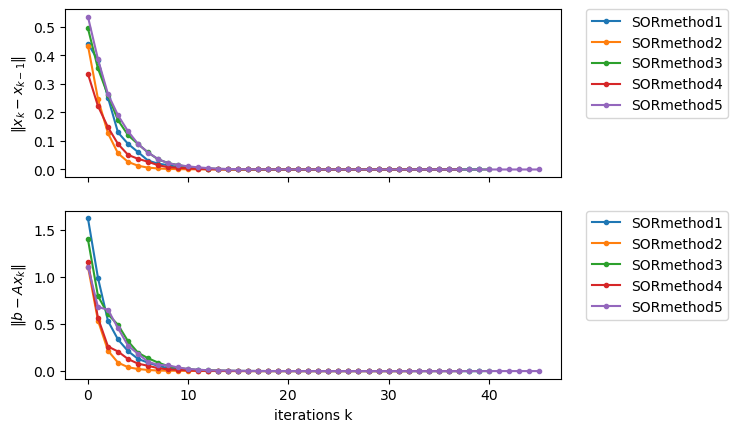

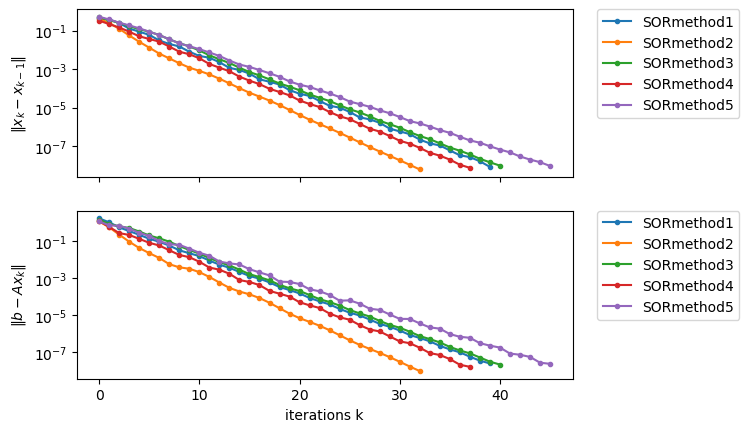

In [563]:
lista =  []
for i in range(5):
    A = rng.random(size=(10, 10))
    np.fill_diagonal(A, A.sum(axis=1))  #優対角
    b = rng.random(10)

    cache_callback_SOR = CacheDiffRes("SORmethod" + str(i + 1))
    lista.append(cache_callback_SOR)
    x = sor(A, b, callback=cache_callback_SOR)

    plot_cache = PlotCacheDiffRes([
        cache_callback_SOR
    ])
#     #fig = plot_cache.plot()
#     fig = plot_cache.plot(y_logscale=True)
# plt.show()
# cache_callback_SOR.get_diff()
# cache_callback_SOR.get_res()


plots = PlotCacheDiffRes(
    lista
)

fig = plots.plot()
fig = plots.plot(y_logscale=True)



<Figure size 1000x600 with 0 Axes>

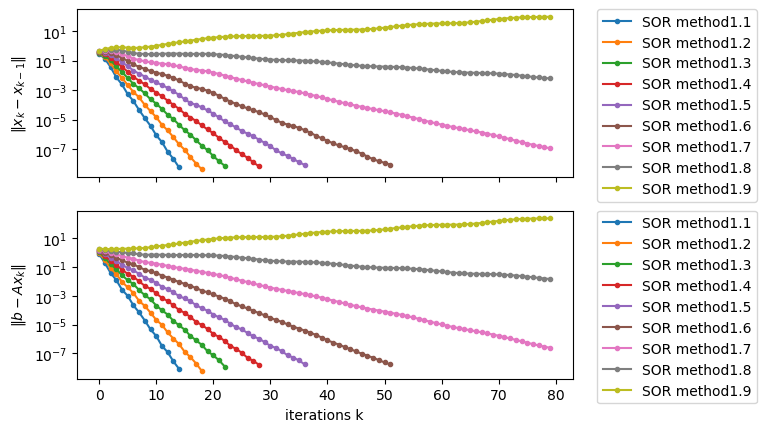

In [ ]:
A = rng.random(size=(10, 10))
np.fill_diagonal(A, A.sum(axis=1))  #優対角
b = rng.random(10)

listb = []
for i in range(11, 20):
    omega = round(i * 0.1, 2)
    cache_callback_SOR = CacheDiffRes("SOR method" + str(omega))
    x = sor(A, b, omega = omega, callback=cache_callback_SOR)
    listb.append(cache_callback_SOR)

    plot_cache = PlotCacheDiffRes([
        cache_callback_SOR
    ])


plots = PlotCacheDiffRes(
    listb
)


fig = plt.figure(figsize=(10, 6))
fig = plots.plot(y_logscale=True)



<Figure size 1000x600 with 0 Axes>

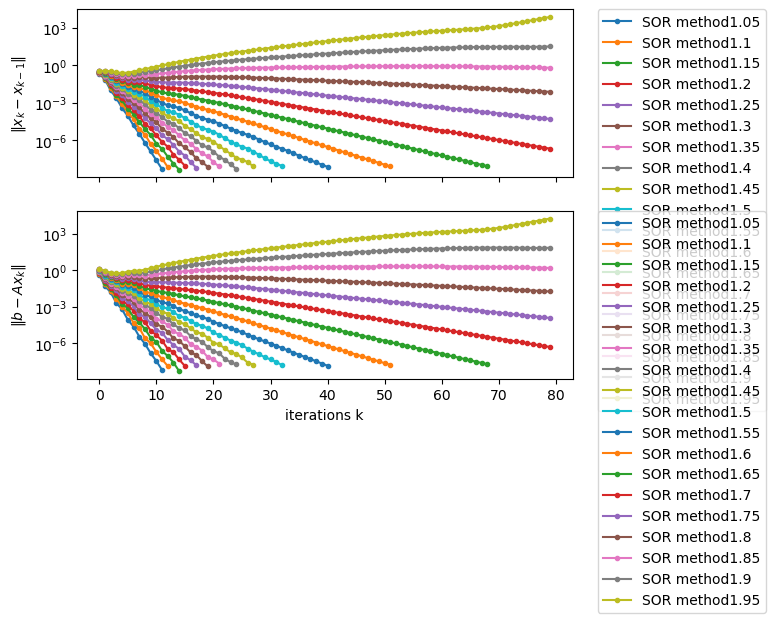

In [572]:
#test

listc = []
A = rng.random(size=(10, 10))
np.fill_diagonal(A, A.sum(axis=1))  #優対角
b = rng.random(10)

for i in range(105,200, 5):
    omega = round(i * 0.01, 2)
    cache_callback_SOR = CacheDiffRes("SOR method" + str(omega))
    x = sor(A, b, omega = omega, callback=cache_callback_SOR)
    listc.append(cache_callback_SOR)
    
    plot_cache = PlotCacheDiffRes([
        cache_callback_SOR
    ])



plots = PlotCacheDiffRes(
    listc
)


fig = plt.figure(figsize=(10, 6))
fig = plots.plot(y_logscale=True)





<Figure size 1000x600 with 0 Axes>

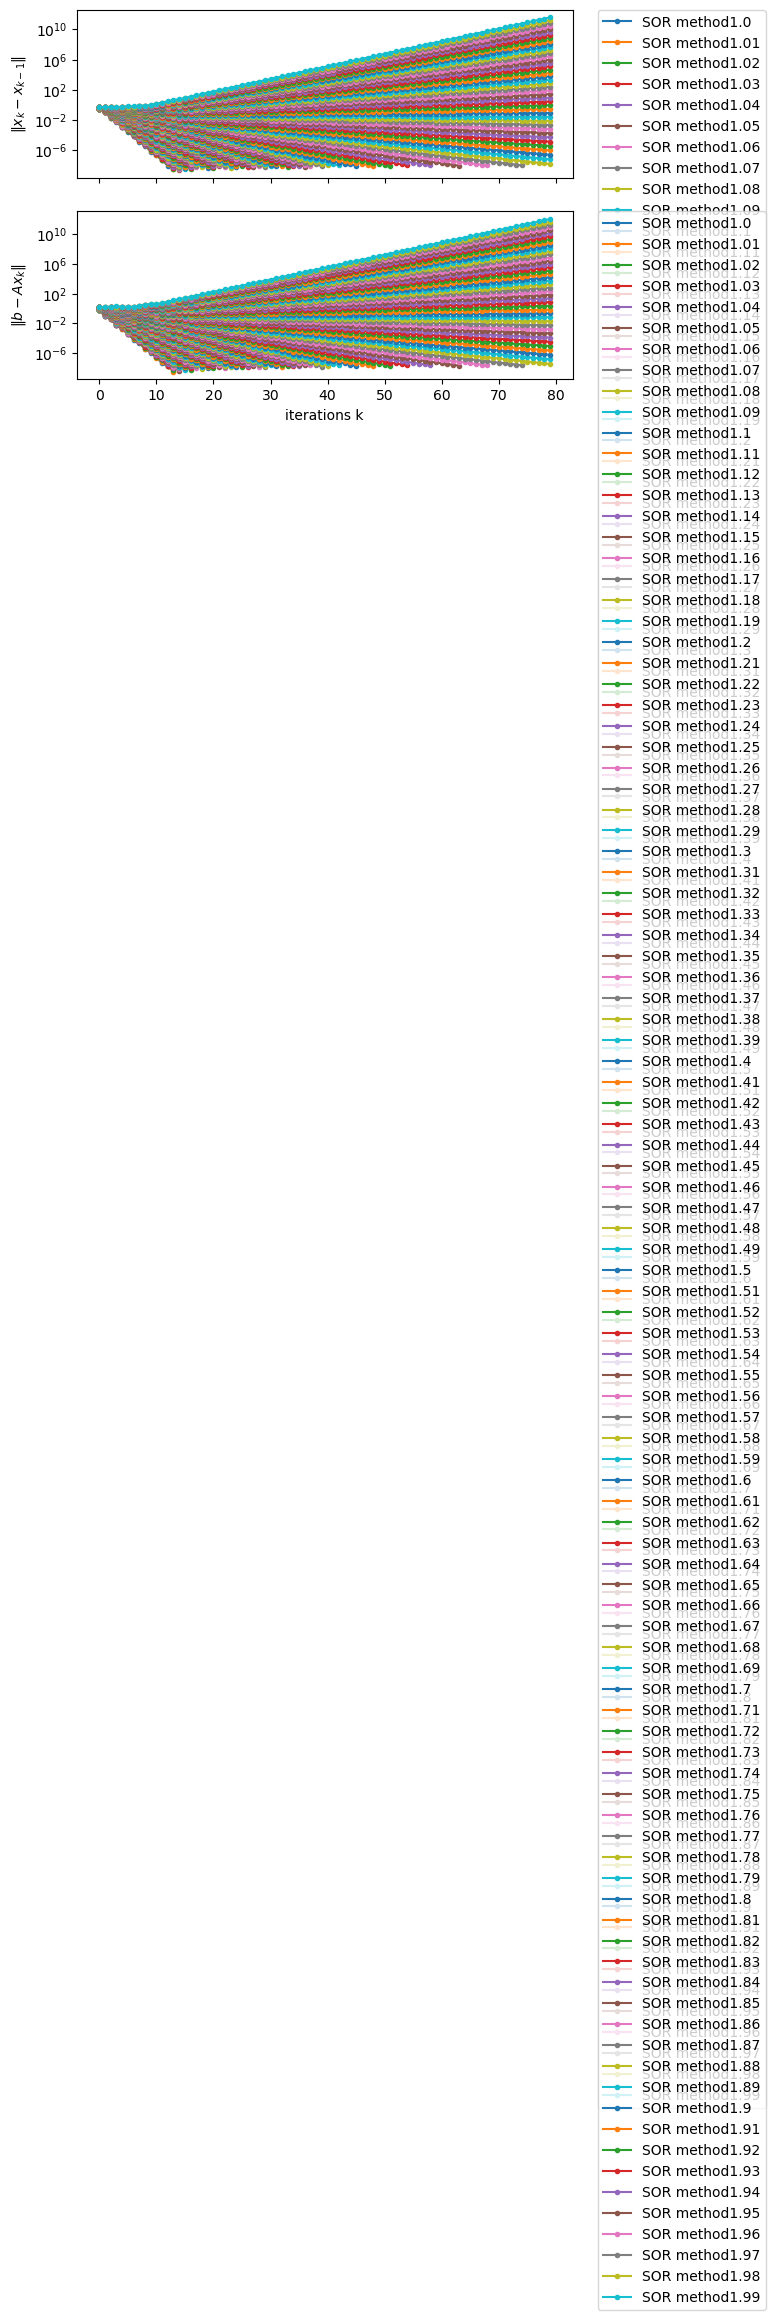

In [579]:
listd = []
A = rng.random(size=(10, 10))
np.fill_diagonal(A, A.sum(axis=1))  #優対角
b = rng.random(10)

for i in range(100,200,):
    omega = i / 100
    cache_callback_SOR = CacheDiffRes("SOR method" + str(omega))
    x = sor(A, b, omega = omega, callback=cache_callback_SOR)
    listd.append(cache_callback_SOR)

    plot_cache = PlotCacheDiffRes([
        cache_callback_SOR
    ])

plots = PlotCacheDiffRes(
    listd
)

fig = plt.figure(figsize=(10, 6))
fig = plots.plot(y_logscale=True)




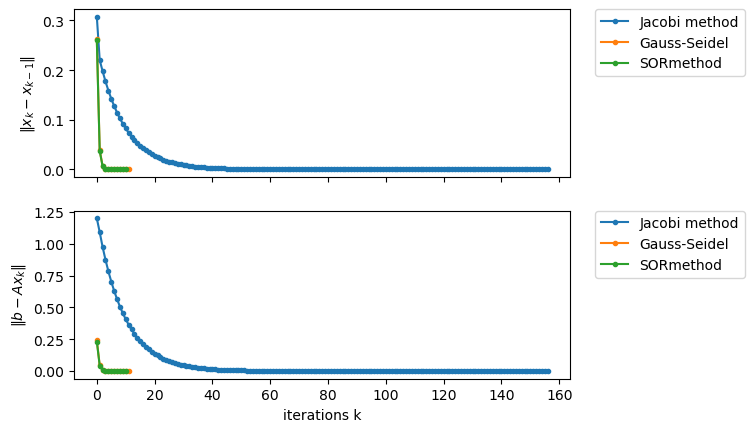

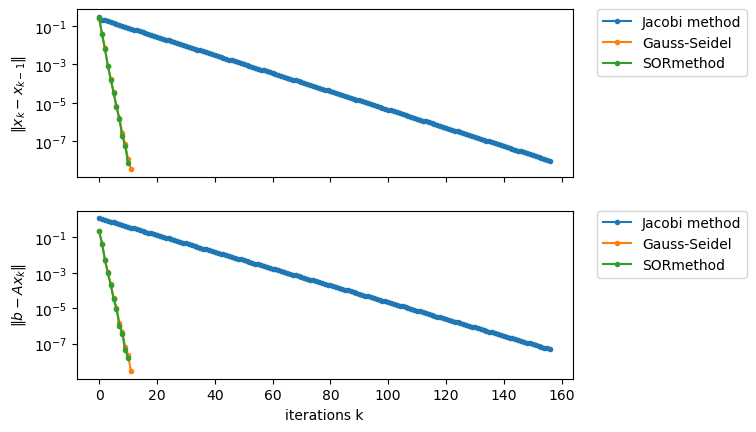

In [578]:
A = rng.random(size=(10, 10))
np.fill_diagonal(A, A.sum(axis=1))  #優対角
b = rng.random(10)

cache_callback_SOR = CacheDiffRes("SORmethod")
x_SOR = sor(A, b,omega = 0.99,  callback=cache_callback_SOR)

cache_callback_jacobi = CacheDiffRes("Jacobi method")
x = jacobi_method(A, b, callback=cache_callback_jacobi)

cache_callback_gauss_seidel = CacheDiffRes("Gauss-Seidel")
x = gauss_seidel(A, b, callback=cache_callback_gauss_seidel)


plot_nya = PlotCacheDiffRes(
    [cache_callback_jacobi, cache_callback_gauss_seidel, cache_callback_SOR]
)





#     #fig = plot_cache.plot()
#     fig = plot_cache.plot(y_logscale=True)
# plt.show()
# cache_callback_SOR.get_diff()
# cache_callback_SOR.get_res()



fig = plot_nya.plot()
fig = plot_nya.plot(y_logscale=True)

